# task description

Simple overview - write script that takes POSCAR and mde workspace as input and plots dispersions along high symmetry path. Some steps could include:
* give crystal structure and it outputs a high symmetry path (seekpath package)
* choose q dimensions
* choose some offset by whole int BZ (depending on coverage, signal strength, rings, etc.)
* choose q bins
* make a slice for each with mantid and save workspace mde
* need to scale each portion so that it is in terms of inv angstrom


# setup

In [1]:
#%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seekpath
from seekpath.util import atoms_num_dict
#from pathSQE_functions import *

In [2]:
from matplotlib.gridspec import GridSpec
from mantid.simpleapi import *
from mantid import plots
import os
import imp
import sys
from reduce_data_to_MDE_07142023 import *
from slice_utils_07142023 import *
sys.path.append('manual_mantid_reduceAndViz')
import define_data

FrameworkManager-[Notice] Welcome to Mantid 6.7.0
FrameworkManager-[Notice] Please cite: http://dx.doi.org/10.1016/j.nima.2014.07.029 and this release: http://dx.doi.org/10.5286/Software/Mantid6.7


the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses


# read poscar for seekpath input

In [3]:
def simple_read_poscar(fname):
    """Read a POSCAR file."""
    with open(fname) as f:
        lines = [l.partition("!")[0] for l in f.readlines()]

    alat = float(lines[1])
    v1 = [float(_) * alat for _ in lines[2].split()]
    v2 = [float(_) * alat for _ in lines[3].split()]
    v3 = [float(_) * alat for _ in lines[4].split()]
    cell = [v1, v2, v3]

    species = lines[5].split()
    num_atoms = [int(_) for _ in lines[6].split()]

    next_line = lines[7]
    if next_line.strip().lower() != "direct":
        raise ValueError("This simple routine can only deal with 'direct' POSCARs")
    # Note: to support also cartesian, remember to multiply the coordinates by alat

    positions = []
    atomic_numbers = []
    cnt = 8
    for el, num in zip(species, num_atoms):
        atom_num = atoms_num_dict[el.capitalize()]
        for _ in range(num):
            atomic_numbers.append(atom_num)
            positions.append([float(_) for _ in lines[cnt].split()])
            cnt += 1

    return (cell, positions, atomic_numbers)

In [4]:
poscar = simple_read_poscar('files_for_nb/POSCAR')
print(poscar)

([[4.65547841329003, -0.0, 0.0], [0.0, 4.65547841329003, -0.0], [0.0, -0.0, 4.65547841329003]], [[0.13476038461486, 0.13476038461486, 0.13476038461486], [0.36523961538514, 0.86523961538514, 0.63476038461486], [0.86523961538514, 0.63476038461486, 0.36523961538514], [0.63476038461486, 0.36523961538514, 0.86523961538514], [0.84874890814554, 0.84874890814554, 0.84874890814554], [0.65125109185446, 0.15125109185446, 0.34874890814554], [0.15125109185446, 0.34874890814554, 0.65125109185446], [0.34874890814554, 0.65125109185446, 0.15125109185446]], [26, 26, 26, 26, 14, 14, 14, 14])


# determining high symmetry path

FeSi unit cell:

<img src="files_for_nb/FeSi_unitCell.png" alt="Alternative text" />

In [5]:
path = seekpath.get_path(structure=poscar)
print(path['path'])
print(path['point_coords'])
print(path.keys())

[('GAMMA', 'X'), ('X', 'M'), ('M', 'GAMMA'), ('GAMMA', 'R'), ('R', 'X'), ('R', 'M'), ('M', 'X_1')]
{'GAMMA': [0.0, 0.0, 0.0], 'R': [0.5, 0.5, 0.5], 'M': [0.5, 0.5, 0.0], 'X': [0.0, 0.5, 0.0], 'X_1': [0.5, 0.0, 0.0]}
dict_keys(['point_coords', 'path', 'has_inversion_symmetry', 'augmented_path', 'bravais_lattice', 'bravais_lattice_extended', 'conv_lattice', 'conv_positions', 'conv_types', 'primitive_lattice', 'primitive_positions', 'primitive_types', 'reciprocal_primitive_lattice', 'inverse_primitive_transformation_matrix', 'primitive_transformation_matrix', 'volume_original_wrt_conv', 'volume_original_wrt_prim', 'spacegroup_number', 'spacegroup_international', 'rotation_matrix'])


Seekpath for FeSi matches the path given by aflow: https://aflow.org/material/?id=aflow:36503a08caf0a17f

Can look at path and BZ in seekpath online tool + visualizer: https://www.materialscloud.org/work/tools/seekpath

<img src="files_for_nb/FeSi_highSymPath1_sm.png" alt="Alternative text" />

<img src="files_for_nb/FeSi_highSymPath_sm.png" alt="Alternative text" />

# choosing dims and bins for slices

Need to be able to choose q dimensions and bins based on the given symmetry endpoints of each path segment. Work through some example by hand to try and understand the algorithm

* For (GAMMA,X)=[(0,0,0),(0,0.5,0)]   !!!MAYBE WRONG!!!

'QDimension0':'1,1,0',

'QDimension1':'-1,1,0',

'QDimension2':'0,0,1',

<br>
'Dimension0Binning':'-0.15,0.15',

'Dimension1Binning':'-0.15,0.15',

'Dimension2Binning':'0,0.025,0.5'

<br>

* For (X,M)=[(0,0.5,0), (0.5,0.5,0)]        !!!ON PAPER!!!

'QDimension0':'1,1,0',

'QDimension1':'-1,1,0',

'QDimension2':'0,0,1',

<br>
'Dimension0Binning':'3.85,4.15',

'Dimension1Binning':'-0.15,0.15',

'Dimension2Binning':'-7.3625,0.025,8.4875'


In [6]:
print(path['path'][0])
print(path['point_coords']['GAMMA'])
print(path['point_coords']['X'])

print('test')
point_cord = path['point_coords']
path_seg = path['path'][0]
path_brav = path['bravais_lattice']
print(path_seg[0])
print(point_cord[path_seg[0]])
print(path_brav)

('GAMMA', 'X')
[0.0, 0.0, 0.0]
[0.0, 0.5, 0.0]
test
GAMMA
[0.0, 0.0, 0.0]
cP


In [7]:
diff = np.array(point_cord[path_seg[1]]) - np.array(point_cord[path_seg[0]])
print(diff)
print(np.nonzero(diff)[0])
scaler = 1/diff[np.nonzero(diff)[0]]
qdim0_range = np.array([-1,0.025,1])
print(qdim0_range*scaler)

[0.  0.5 0. ]
[1]
[-2.    0.05  2.  ]


In [8]:
diff3d = np.array([0.3,0,0.75])
print(diff3d)
print(np.nonzero(diff3d)[0])
minDiffNonZero = np.min(diff3d[np.nonzero(diff3d)[0]])
scaler = 1/minDiffNonZero
def_range = np.array([-1,0.025,1])
qdim0_range = def_range*scaler
print(qdim0_range)

[0.3  0.   0.75]
[0 2]
[-3.33333333  0.08333333  3.33333333]


In [9]:
h = np.array([1,0,0])
k = np.array([0,1,0])
l = np.array([0,0,1])

#qdim0 = np.array(point_cord[path_seg[1]]) - np.array(point_cord[path_seg[0]])
qdim0 = np.array([0.3,0,0.75])
unit_qdim0 = qdim0 / np.linalg.norm(qdim0)
print(unit_qdim0)
print("h parallel score: {}".format(np.dot(unit_qdim0,h)))
print("k parallel score: {}".format(np.dot(unit_qdim0,k)))
print("l parallel score: {}".format(np.dot(unit_qdim0,l)))


[0.37139068 0.         0.92847669]
h parallel score: 0.3713906763541037
k parallel score: 0.0
l parallel score: 0.9284766908852594


Helpful links:
* Angle btw two vecs: https://www.emathhelp.net/en/calculators/linear-algebra/angle-between-two-vectors-calculator/?u=0.25%2C0.75%2C0.5&v=0.75%2C-0.25%2C0

* Cross product calc: https://www.symbolab.com/solver/vector-cross-product-calculator/%5Cbegin%7Bpmatrix%7D0.25%260.75%260.5%5Cend%7Bpmatrix%7D%5Ctimes%5Cbegin%7Bpmatrix%7D0.75%26-0.25%260%5Cend%7Bpmatrix%7D?or=input

* Find plane eq given 3 points: https://keisan.casio.com/exec/system/1223596129

* Geogebra 3D viz: https://www.geogebra.org/3d?lang=en 

In [10]:
def calc_para_scores(qdim0):
    hkl = np.array([[1,0,0],[0,1,0],[0,0,1]])
    unit_qdim0 = qdim0 / np.linalg.norm(qdim0)
    # calculate degree of parallelism btw qdim0 and hkl vecs
    para_scores = np.zeros((3,1))
    for i in range(3):
        para_scores[i] = np.dot(unit_qdim0,hkl[i])
    return para_scores


def find_qdim_1and2(qdim0, perp_to_path=False):
    hkl = np.array([[1,0,0],[0,1,0],[0,0,1]])
    # if non-default perp to path method is wanted
    if perp_to_path:
        if np.count_nonzero(qdim0) == 1:
            # if diff=dim0 is 1D, then dim1 and dim2 will also just be 1D h,k,or l
            qdim0_dir = np.nonzero(qdim0)[0]
            hkl_avail = np.delete(hkl, qdim0_dir, axis=0)
            qdim1 = hkl_avail[0]
            qdim2 = hkl_avail[1]
        elif (np.count_nonzero(qdim0) == 2) or (np.count_nonzero(qdim0) == 3):
            nzeroInds = np.nonzero(qdim0)[0]
            qdim1 = qdim0.copy()
            # swap h and k and make one negative to give perpen direction within the horizontal plane
            # If qdim0 is 3D, need to set l to 0 so that it is perpen and in the horizontal plane 
            qdim1[nzeroInds[0]], qdim1[nzeroInds[1]] = qdim0[nzeroInds[1]], -qdim0[nzeroInds[0]]
            if np.count_nonzero(qdim0) == 3:
                qdim1[2] = 0 
            # qdim2 is simply the direction perpen to qdim0 and qdim1
            qdim2 = np.cross(qdim0, qdim1)
            qdim2 = qdim2 / np.max(np.absolute(qdim2))
            # MAYBE DON'T (messing w bin offset) - normalize the two qdims so that mag of each is 1 A-1 and can easily do bins +/- 0.15
            #qdim1 = qdim1 / np.linalg.norm(qdim1)
            #qdim2 = qdim2 / np.linalg.norm(qdim2)
        else:
            raise ValueError("The selected symmetry path contains a segment which is greater than 3 dimensions") 
    else:
        # if perp to path isn't wanted, do it based on which 2 hkl are most perp (i.e. least para) to dim0
        para_scores = calc_para_scores(qdim0)
        # want two directions most perpen to qdim0 to be qdim1 and qdim2
        qdim1_ind = np.argmin(para_scores)
        qdim1 = hkl[qdim1_ind]
        # set qdim1 as highest so it won't be chosen for qdim2
        para_scores[qdim1_ind] = 2
        qdim2_ind = np.argmin(para_scores)
        qdim2 = hkl[qdim2_ind]
    return qdim1, qdim2


def find_qbins(qdim0, qdim1, qdim2, pt1, pt2, BZ_offset):
    # we start with bins of 0 so hopefully can catch it if code isn't working
    qdim1_range = 0
    qdim2_range = 0 

    # find the new path endpoint coords given change of basis from cart to qdim0,1,2
    CoB_mat = np.linalg.inv(np.array([qdim0,qdim1,qdim2]).T)
    path_start_transf = CoB_mat @ (pt1 + BZ_offset)
    path_end_transf = CoB_mat @ (pt2 + BZ_offset)
    
    # fixed step size of 0.025 for qdim0 from path start to end
    qdim0_range = np.array([path_start_transf[0], 0.025, path_end_transf[0]])
    
    # might need to check bin/path endpoints...
    # old check_bin0_and_path_endpoints function
    
    # fixed integration range of +/-0.1 for qdim1 and qdim2
    qdim1_range = np.array([path_start_transf[1]-0.1, path_end_transf[1]+0.1])
    qdim2_range = np.array([path_start_transf[2]-0.1, path_end_transf[2]+0.1])
    
    # if qdim1 or qdim2 bin range gets too big raise error because code above may be wrong...
    #if (np.absolute(qdim1_range[1]-qdim1_range[0]) > 0.2) or (np.absolute(qdim2_range[1]-qdim2_range[0]) > 0.2):
    #    raise ValueError("Might be something weird with bins for qdim1 or dqim2")
    
    return qdim0_range, qdim1_range, qdim2_range


tests

In [11]:
qdim0 = np.array([0.6,0,0.75])
qdim1,qdim2 = find_qdim_1and2(qdim0, perp_to_path=True)
print(qdim1,qdim2)

qdim0 = np.array([0.6,0,0.75])
qdim1,qdim2 = find_qdim_1and2(qdim0, perp_to_path=False)
print(qdim1,qdim2)

print("\ntest2:")
qdim0 = np.array([0.5,0.5,0])
qdim1,qdim2 = find_qdim_1and2(qdim0, perp_to_path=True)
print(qdim1,qdim2)

[ 0.75  0.   -0.6 ] [-0.  1.  0.]
[0 1 0] [1 0 0]

test2:
[ 0.5 -0.5  0. ] [ 0.  0. -1.]


dev

In [12]:
#qdim0tst = np.array([0.25,0.75,0.5])
qdim0tst = np.array([0.5,0.5,0.5])
#qdim0tst = np.array([1,0,0])
hkl = np.array([[1,0,0],[0,1,0],[0,0,1]])
zeroInds = np.where(qdim0tst == 0)[0]
nzeroInds = np.nonzero(qdim0tst)[0]
print(zeroInds)
print(nzeroInds)
qdim1tst = qdim0tst.copy()
qdim1tst[nzeroInds[0]], qdim1tst[nzeroInds[1]] = -qdim0tst[nzeroInds[1]], qdim0tst[nzeroInds[0]]
if np.count_nonzero(qdim0tst) == 3:
    qdim1tst[2] = 0 
qdim2tst = np.cross(qdim0tst, qdim1tst)
qdim1tst = qdim1tst / np.linalg.norm(qdim1tst)
qdim2tst = qdim2tst / np.linalg.norm(qdim2tst)
print(qdim0tst)
print(qdim1tst)
print(qdim2tst)

[]
[0 1 2]
[0.5 0.5 0.5]
[-0.70710678  0.70710678  0.        ]
[-0.40824829 -0.40824829  0.81649658]


driver function for dim and bin selection

In [13]:
def choose_dims_and_bins(path_segment, point_coords, perp_to_path=False, BZ_offset=np.array([0,0,0])):
    pt1 = np.array(point_coords[path_segment[0]])
    pt2 = np.array(point_coords[path_segment[1]])
    diff = pt2 - pt1

    # calculating default QDimension0 axis direction and scaling
    qdim0 = diff / np.max(np.absolute(diff))

    # determine the directions of qdim1 and qdim2
    qdim1, qdim2 = find_qdim_1and2(qdim0,perp_to_path)
    qdim0_range, qdim1_range, qdim2_range = find_qbins(qdim0, qdim1, qdim2, pt1, pt2, BZ_offset)

    # return list contains various types (mainly np arrays) that are converted to properly formatted strings
    # as a part of the slice description generation process
    q_dims_and_bins = [qdim0, qdim1, qdim2, qdim0_range, qdim1_range, qdim2_range]
    return q_dims_and_bins


driver test

In [14]:
path_seg = path['path'][0]
point_cord = path['point_coords']
path_brav = path['bravais_lattice']
print(path_seg)
print(point_cord)
print(path_brav)

q_dims_and_bins = choose_dims_and_bins(path_seg,point_cord,perp_to_path=True) 
print(q_dims_and_bins)

('GAMMA', 'X')
{'GAMMA': [0.0, 0.0, 0.0], 'R': [0.5, 0.5, 0.5], 'M': [0.5, 0.5, 0.0], 'X': [0.0, 0.5, 0.0], 'X_1': [0.5, 0.0, 0.0]}
cP
[array([0., 1., 0.]), array([1, 0, 0]), array([0, 0, 1]), array([0.   , 0.025, 0.5  ]), array([-0.1,  0.1]), array([-0.1,  0.1])]


In [15]:
poscar = simple_read_poscar('files_for_nb/POSCAR')
path = seekpath.get_path(structure=poscar)

dims_and_bins_list=[]
for i in range(5): #range(len(path['path'])):
    print("on path seg {}".format(i))
    path_seg = path['path'][i]
    q_dims_and_bins = choose_dims_and_bins(path_seg,path['point_coords'],perp_to_path=True)
    dims_and_bins_list.append(q_dims_and_bins)

on path seg 0
on path seg 1
on path seg 2
on path seg 3
on path seg 4


In [16]:
for i in range(5):
    print("\npath segment {} from {} to {}".format(i, path['path'][i][0], path['path'][i][1]))
    print(dims_and_bins_list[i])


path segment 0 from GAMMA to X
[array([0., 1., 0.]), array([1, 0, 0]), array([0, 0, 1]), array([0.   , 0.025, 0.5  ]), array([-0.1,  0.1]), array([-0.1,  0.1])]

path segment 1 from X to M
[array([1., 0., 0.]), array([0, 1, 0]), array([0, 0, 1]), array([0.   , 0.025, 0.5  ]), array([0.4, 0.6]), array([-0.1,  0.1])]

path segment 2 from M to GAMMA
[array([-1., -1.,  0.]), array([-1.,  1.,  0.]), array([-0.,  0., -1.]), array([-0.5  ,  0.025,  0.   ]), array([-0.1,  0.1]), array([-0.1,  0.1])]

path segment 3 from GAMMA to R
[array([1., 1., 1.]), array([ 1., -1.,  0.]), array([ 0.5,  0.5, -1. ]), array([0.   , 0.025, 0.5  ]), array([-0.1,  0.1]), array([-0.1,  0.1])]

path segment 4 from R to X
[array([-1.,  0., -1.]), array([-1.,  0.,  1.]), array([0., 1., 0.]), array([-0.5  ,  0.025,  0.   ]), array([-0.1,  0.1]), array([0.4, 0.6])]


# making slice descriptions

In [17]:
test_slice={'QDimension0':'1,1,0',
            'QDimension1':'-1,1,0',
            'QDimension2':'0,0,1',
            'Dimension0Name':'QDimension0',
            'Dimension0Binning':'3.85,4.15',
            'Dimension1Name':'QDimension1',
            'Dimension1Binning':'-0.15,0.15',
            'Dimension2Name':'QDimension2',
            'Dimension2Binning':'-7.3625,0.025,8.4875',
            'Dimension3Name':'DeltaE',
            'Dimension3Binning':'-35.5,1,66.5',
            'SymmetryOperations':'x,y,z'}

In [18]:
def conv_to_desc_string(input_item):
    # works for np arrays, lists, and tuples
    string = ''
    for item in input_item:
        string = string + str(item) +','
    string = string[:-1]
    return string

In [19]:
print(test_slice['QDimension0'])
qdim2= 1,1,0
tst_str = conv_to_desc_string(qdim2)
print(tst_str)
print(test_slice['QDimension0'] == tst_str)

dim3= [1,1,0]
tst_str2 = conv_to_desc_string(dim3)
print(tst_str2)
print(test_slice['QDimension0'] == tst_str2)

dim4= np.array([1,1,0])
tst_str4 = conv_to_desc_string(dim4)
print(tst_str4)
print(test_slice['QDimension0'] == tst_str4)

1,1,0
1,1,0
True
1,1,0
True
1,1,0
True


replacing dim in slice desc dict with the converted one

In [20]:
print(test_slice['QDimension0'])
dim3= [1,2,0]
tst_str2 = conv_to_desc_string(dim3)
print(tst_str2)
test_slice['QDimension0'] = tst_str2
print(test_slice['QDimension0'])

1,1,0
1,2,0
1,2,0


function to make slice description

In [133]:
def make_slice_desc(q_dims_and_bins, path_seg, point_coords):
    pt1 = np.array(point_coords[path_seg[0]])
    pt2 = np.array(point_coords[path_seg[1]])
    diff = pt2 - pt1
    
    # slice description with desired dims and bins and unique name
    slice_desc={'QDimension0':conv_to_desc_string(q_dims_and_bins[0]),
                'QDimension1':conv_to_desc_string(q_dims_and_bins[1]),
                'QDimension2':conv_to_desc_string(q_dims_and_bins[2]),
                'Dimension0Name':'QDimension0',
                'Dimension0Binning':conv_to_desc_string(q_dims_and_bins[3]),
                'Dimension1Name':'QDimension1',
                'Dimension1Binning':conv_to_desc_string(q_dims_and_bins[4]),
                'Dimension2Name':'QDimension2',
                'Dimension2Binning':conv_to_desc_string(q_dims_and_bins[5]),
                'Dimension3Name':'DeltaE',
                'Dimension3Binning':'-35.5,1,66.5',
                'SymmetryOperations':'x,y,z',
                'Name':'pathSQE_'+path_seg[0]+'_to_'+path_seg[1],
                'qdim0_range':q_dims_and_bins[3],
                'seg_start_name':path_seg[0],
                'seg_end_name':path_seg[1],
                'inv_angstrom_ratio':np.linalg.norm(diff)/0.5}

    return slice_desc


In [38]:
poscar = simple_read_poscar('files_for_nb/POSCAR')
path = seekpath.get_path(structure=poscar)

path_seg = path['path'][3]
point_coords = path['point_coords']

pt1 = np.array(point_coords[path_seg[0]])
pt2 = np.array(point_coords[path_seg[1]])
diff = pt2 - pt1
print(np.linalg.norm(diff)/0.5)

1.7320508075688772


test

In [ ]:
exSlice = make_slice_desc(q_dims_and_bins, ('G','L'))
print(exSlice)

# combine whole process and make all slices descriptions at once

In [42]:
poscar = simple_read_poscar('files_for_nb/POSCAR')
path = seekpath.get_path(structure=poscar)

dsl=[]
# APPEARS IT MAY NOT BE ABLE TO HANDLE DISCONTINUITIES IN PATH YET (e.g. R>X then R>M (path[5]))
for i in range(5): #range(len(path['path'])):
    #print("on path seg {}".format(i))
    path_seg = path['path'][i]
    #print(path_seg)
    q_dims_and_bins = choose_dims_and_bins(path_seg,path['point_coords'],perp_to_path=True)
    slice_desc = make_slice_desc(q_dims_and_bins, path_seg, path['point_coords'])
    dsl.append(slice_desc)

print(dsl)

[{'QDimension0': '0.0,1.0,0.0', 'QDimension1': '1,0,0', 'QDimension2': '0,0,1', 'Dimension0Name': 'QDimension0', 'Dimension0Binning': '0.0,0.025,0.5', 'Dimension1Name': 'QDimension1', 'Dimension1Binning': '-0.1,0.1', 'Dimension2Name': 'QDimension2', 'Dimension2Binning': '-0.1,0.1', 'Dimension3Name': 'DeltaE', 'Dimension3Binning': '-35.5,1,66.5', 'SymmetryOperations': 'x,y,z', 'Name': 'pathSQE_GAMMA_to_X', 'inv_angstrom_ratio': 1.0}, {'QDimension0': '1.0,0.0,0.0', 'QDimension1': '0,1,0', 'QDimension2': '0,0,1', 'Dimension0Name': 'QDimension0', 'Dimension0Binning': '0.0,0.025,0.5', 'Dimension1Name': 'QDimension1', 'Dimension1Binning': '0.4,0.6', 'Dimension2Name': 'QDimension2', 'Dimension2Binning': '-0.1,0.1', 'Dimension3Name': 'DeltaE', 'Dimension3Binning': '-35.5,1,66.5', 'SymmetryOperations': 'x,y,z', 'Name': 'pathSQE_X_to_M', 'inv_angstrom_ratio': 1.0}, {'QDimension0': '-1.0,-1.0,0.0', 'QDimension1': '-1.0,1.0,0.0', 'QDimension2': '-0.0,0.0,-1.0', 'Dimension0Name': 'QDimension0', 'Di

In [24]:
#dsl = make_all_slice_descs(path_to_poscar='files_for_nb/POSCAR')
#print(dsl)

# take slices w/ Mantid python API

In [25]:
imp.reload(define_data)

mde_data=define_data.define_data_set()
reduce_data_to_MDE(mde_data)

for i in range(len(dsl)):
    make_slice(mde_data[0],dsl[i], ASCII_slice_folder='', MD_slice_folder='')

Try loading MDE from /SNS/ARCS/IPTS-21211/shared/Aiden/merged_mde/FeSi_650K_70meV_UBcorrected.nxs
LoadMD-[Notice] LoadMD started
Loading normalization and masking file /SNS/ARCS/IPTS-21211/shared/Dipanshu/van108467_new.nxs
LoadMD-[Notice] LoadMD successful, Duration 3 minutes 41.81 seconds
Load-[Notice] Load started
Load-[Notice] Load successful, Duration 3.71 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 17.44 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 17.28 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 17.06 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 17.57 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 17.53 seconds


# Plotting slices

In [26]:
x = mtd['pathSQE_GAMMA_to_X']
print(x.name())

pathSQE_GAMMA_to_X


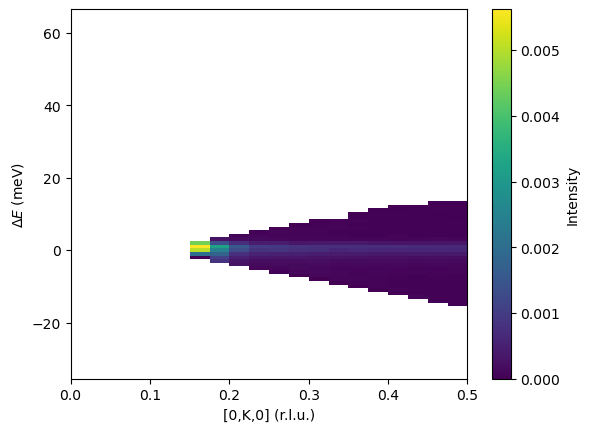

In [27]:
fig,ax=plt.subplots(subplot_kw={'projection':'mantid'})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.set_cmap('viridis')
c=plot_slice(dsl[0], ax=ax, cbar_label='Intensity')
fig.show()    

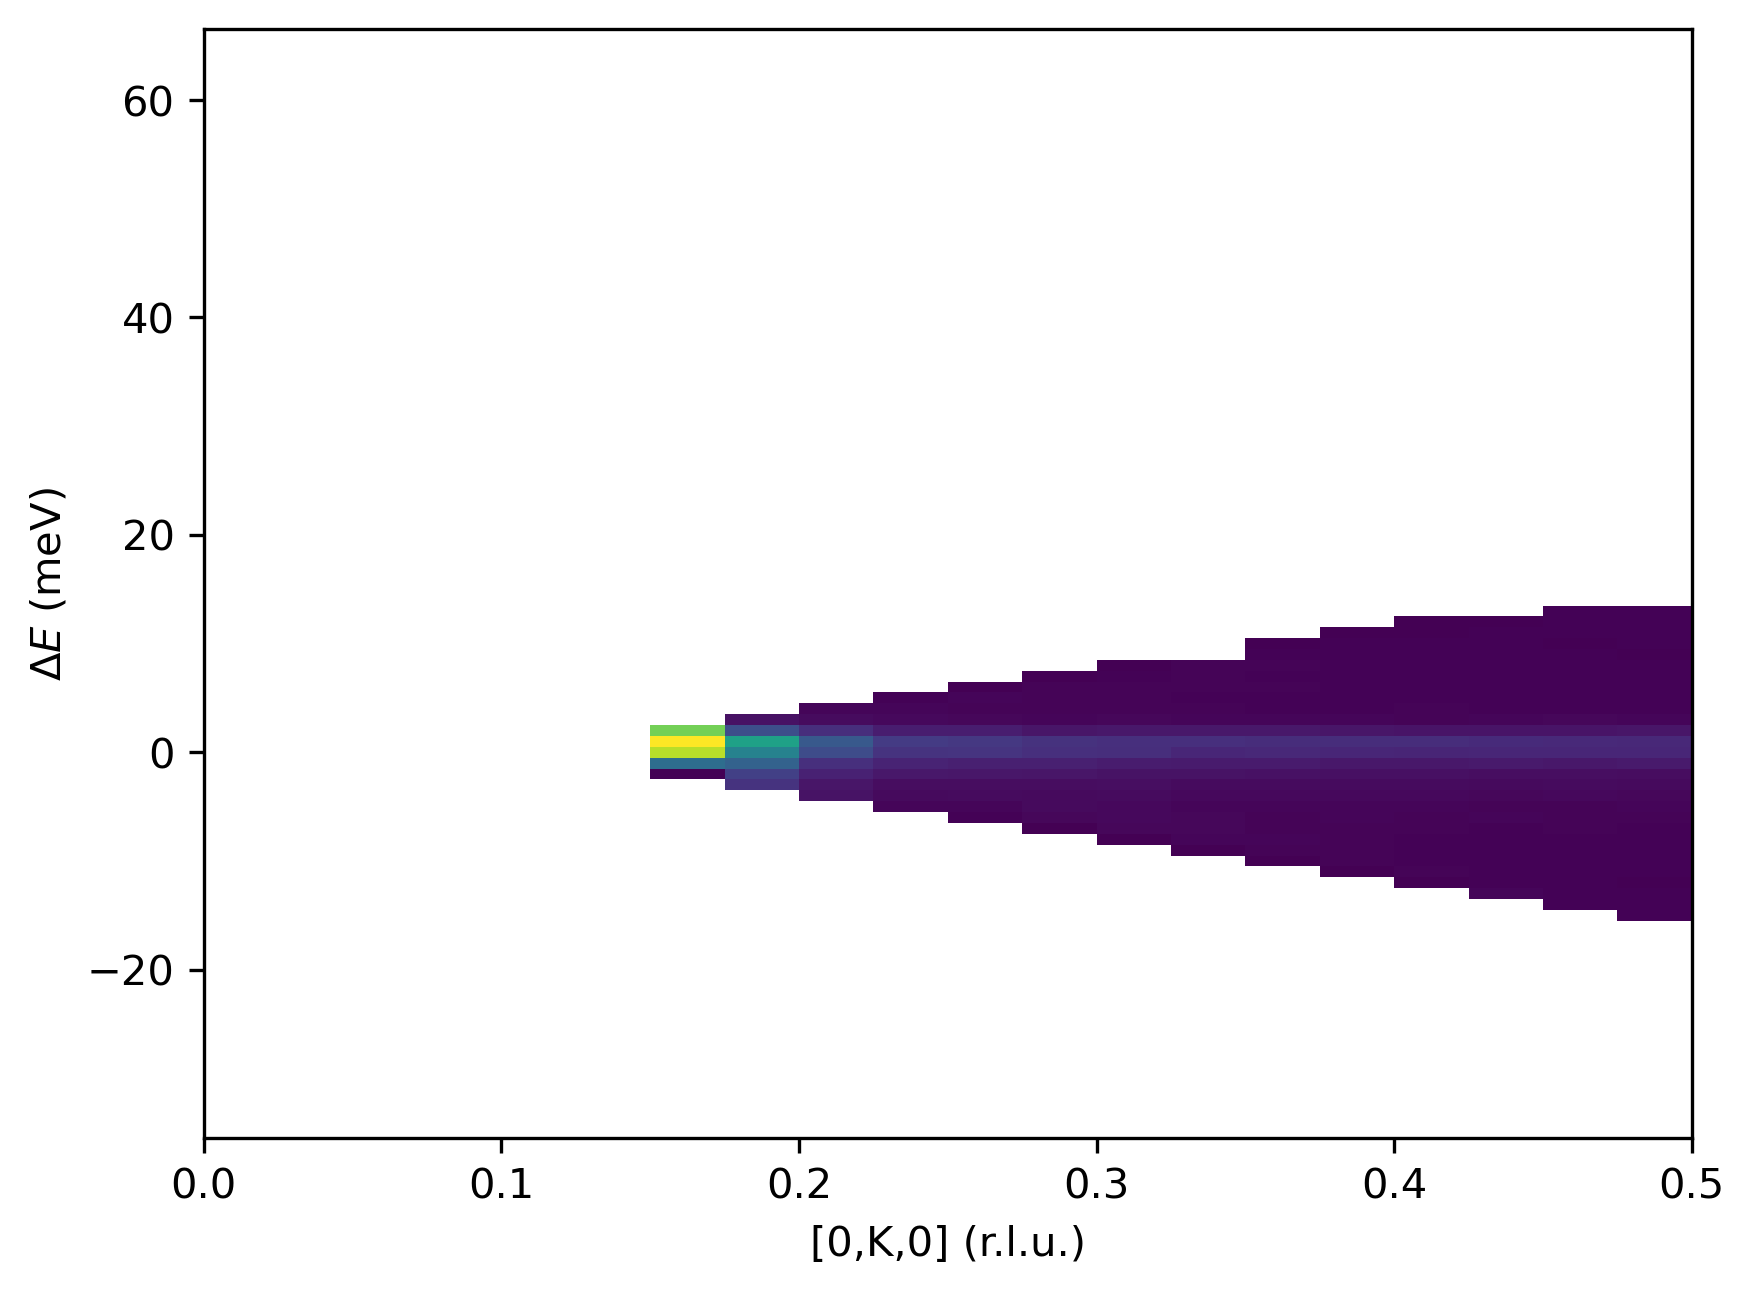

In [28]:
fig,ax=plt.subplots(subplot_kw={'projection':'mantid'})
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.set_cmap('viridis')
slice_plot=ax.pcolormesh(mtd['pathSQE_GAMMA_to_X'])
fig.show()

In [29]:
#print(len(dsl))
#print(dsl[0].get('QDimension0'))
#print(dsl[0].get('Dimension0Binning'))

for i in range(5):
    print("\nslice number {}".format(i))
    print("QDim0: "+dsl[i].get('QDimension0'))
    print("QDim1: "+dsl[i].get('QDimension1'))
    print("QDim2: "+dsl[i].get('QDimension2'))


slice number 0
QDim0: 0.0,1.0,0.0
QDim1: 1,0,0
QDim2: 0,0,1

slice number 1
QDim0: 1.0,0.0,0.0
QDim1: 0,1,0
QDim2: 0,0,1

slice number 2
QDim0: -1.0,-1.0,0.0
QDim1: -1.0,1.0,0.0
QDim2: -0.0,0.0,-1.0

slice number 3
QDim0: 1.0,1.0,1.0
QDim1: 1.0,-1.0,0.0
QDim2: 0.5,0.5,-1.0

slice number 4
QDim0: -1.0,0.0,-1.0
QDim1: -1.0,0.0,1.0
QDim2: 0.0,1.0,0.0


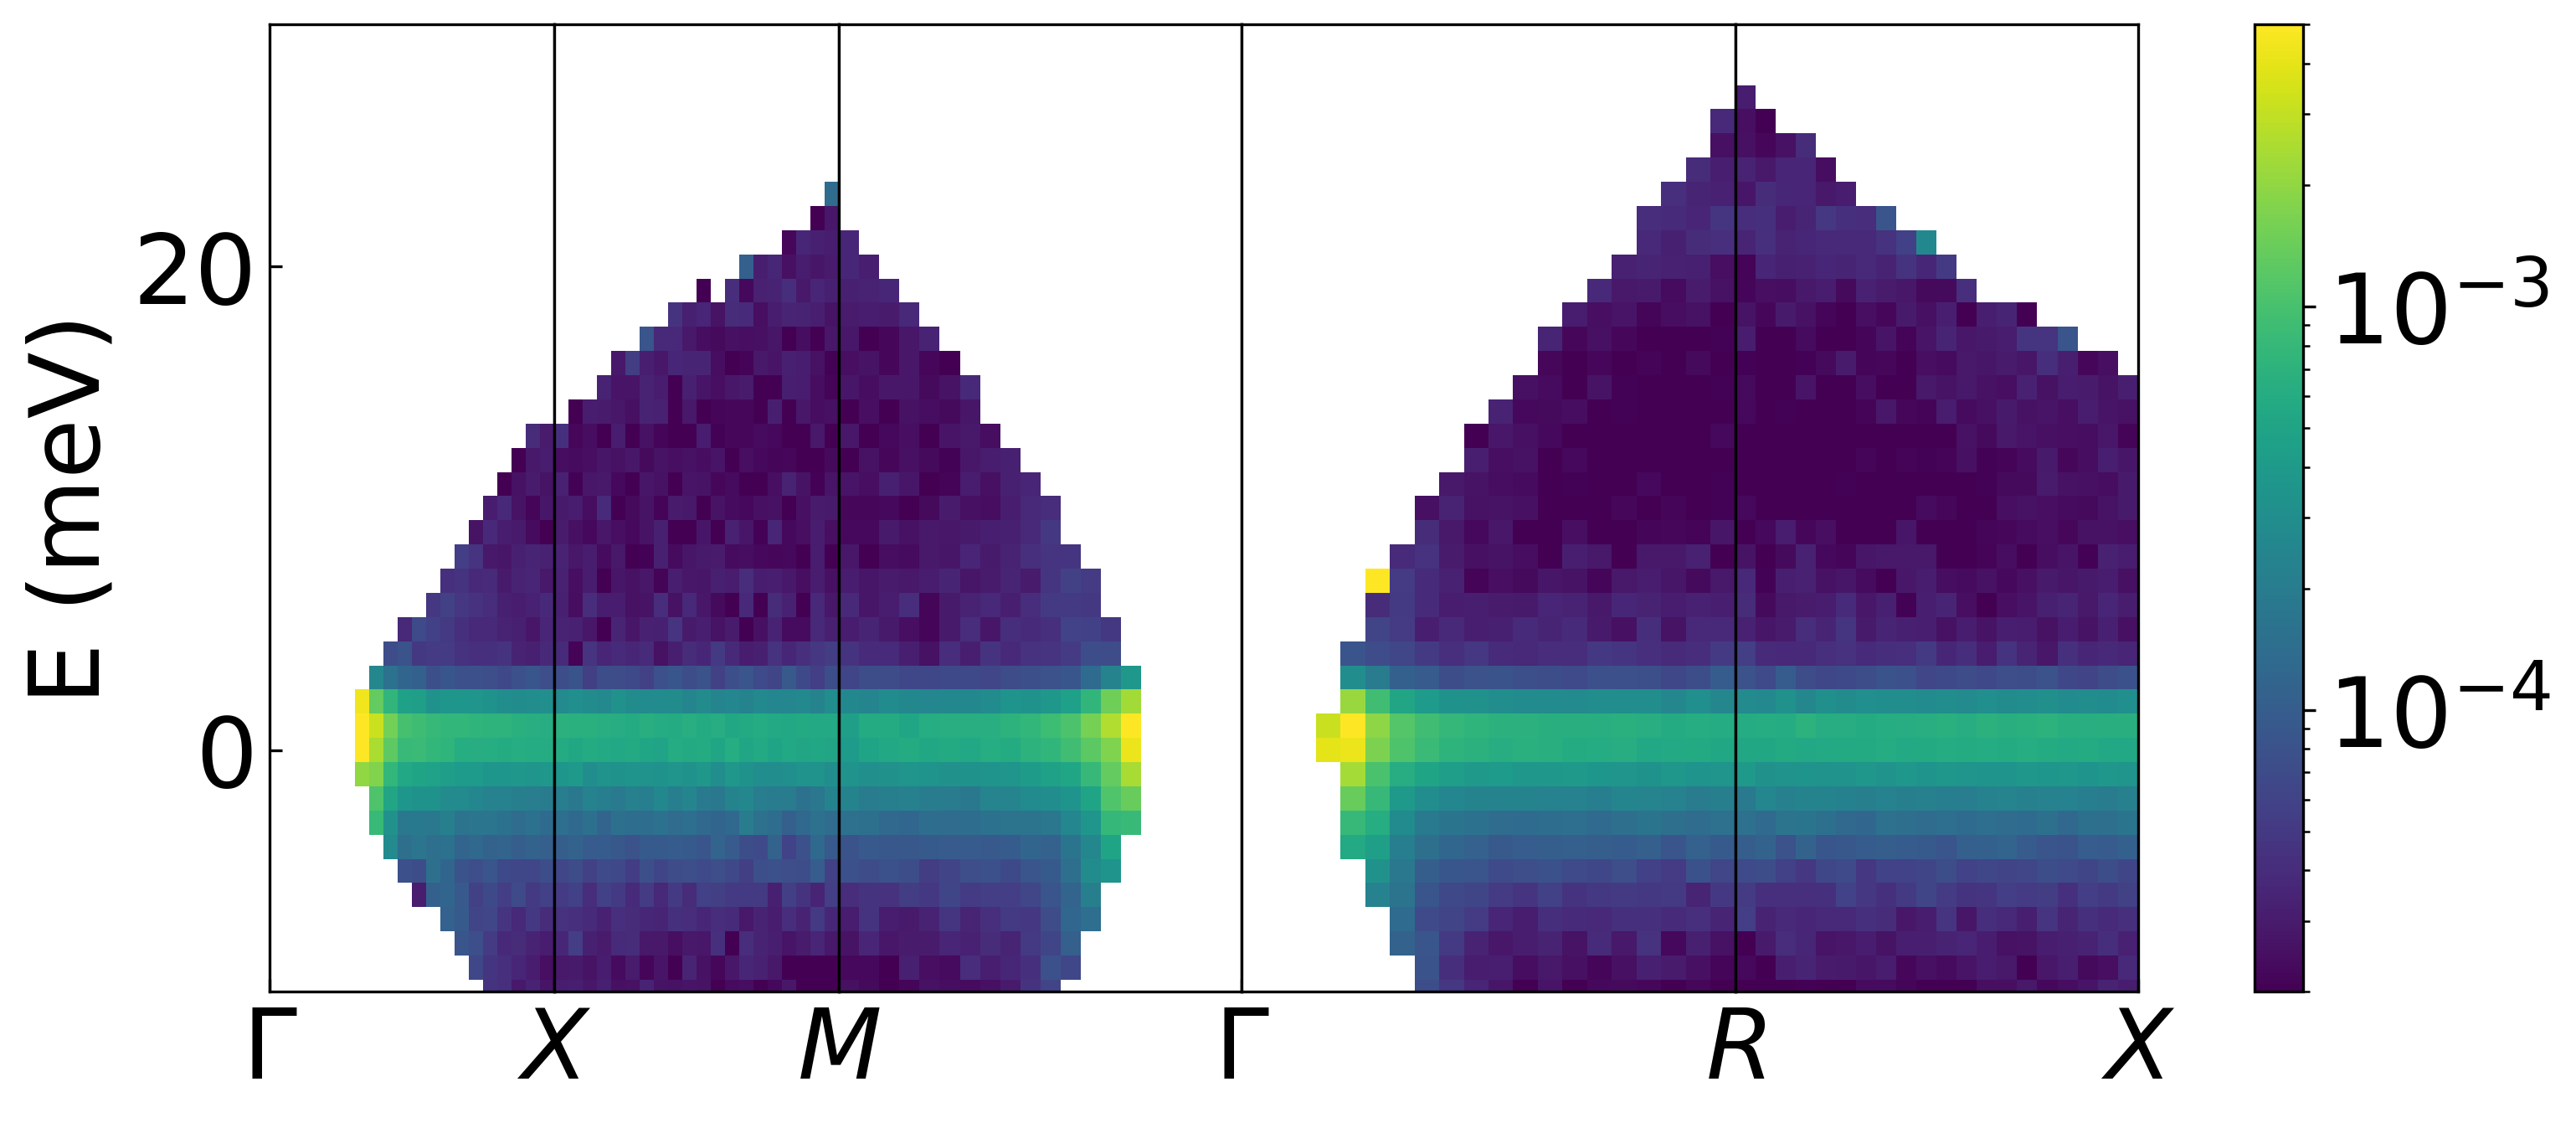

In [30]:
# https://docs.mantidproject.org/nightly/plotting/index.html#plotting 
# Manually plot the path for the FeSi data


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams.update({'font.size': 28})

fig=plt.figure(figsize=(12,5))

colormesh_pars={}
colormesh_pars['norm']=LogNorm(vmin=0.00002,vmax=0.005)
colormesh_pars['cmap']='viridis'


a=4.489
m_gamma = np.sqrt(2)
gamma_r = np.sqrt(3)
r_x = np.sqrt(2)
gs = GridSpec(1, 5,width_ratios=[1,1,m_gamma,gamma_r,r_x],wspace=0)


#fig,ax=plt.subplots(subplot_kw={'projection':'mantid'})
#slice_plot=ax.pcolormesh(mtd['pathSQE_GAMMA_to_X'])

ax1 = plt.subplot(gs[0],projection='mantid')
ax2 = plt.subplot(gs[1],sharey=ax1,projection='mantid')
ax3 = plt.subplot(gs[2],sharey=ax1,projection='mantid')
ax4 = plt.subplot(gs[3],sharey=ax1,projection='mantid')
ax5 = plt.subplot(gs[4],sharey=ax1,projection='mantid')


pcm=ax1.pcolormesh(mtd['pathSQE_GAMMA_to_X'], **colormesh_pars)
ax2.pcolormesh(mtd['pathSQE_X_to_M'], **colormesh_pars)
ax3.pcolormesh(mtd['pathSQE_M_to_GAMMA'],  **colormesh_pars)#cmap='viridis', norm=LogNorm(vmin=0.00005,vmax=0.005))
ax4.pcolormesh(mtd['pathSQE_GAMMA_to_R'], **colormesh_pars) #cmap='viridis', norm=LogNorm(vmin=0.00005,vmax=0.005))
ax5.pcolormesh(mtd['pathSQE_R_to_X'], **colormesh_pars)


#Adjust plotting parameters
ax1.set_ylabel('E (meV)')
ax1.set_xlabel('')
ax1.set_ylim(-10.,30.)
ax1.set_yticks([0,20])
ax1.set_xlim(0,0.5)
ax1.set_xticks([0,0.5])
ax1.set_xticklabels(['$\Gamma$','$X$'])
ax1.tick_params(direction='in')

ax2.get_yaxis().set_visible(False)
ax2.set_xlabel('')
ax2.set_xlim(0,0.5)
ax2.set_xticks([0.5])
ax2.set_xticklabels(['$M$'])
ax2.tick_params(direction='in')

ax3.get_yaxis().set_visible(False)
ax3.set_xlabel('')
ax3.set_xlim(-0.5,0)
ax3.set_xticks([0])
ax3.set_xticklabels(['$\Gamma$'])
ax3.tick_params(direction='in')

ax4.get_yaxis().set_visible(False)
ax4.set_xlabel('')
ax4.set_xlim(0,0.5)
ax4.set_xticks([0.5])
ax4.set_xticklabels(['$R$'])
ax4.tick_params(direction='in')

ax5.get_yaxis().set_visible(False)
ax5.set_xlabel('')
ax5.set_xlim(-0.5,0)
ax5.set_xticks([0])
ax5.set_xticklabels(['$X$'])
ax5.tick_params(direction='in')

fig.colorbar(pcm, ax=[ax1,ax2,ax3,ax4,ax5])

#fig.show()
#plt.close('all')

In [145]:
# https://docs.mantidproject.org/nightly/plotting/index.html#plotting 
# Manually plot the path for the FeSi data
def plot_along_path(dsl,vmi,vma,cma='jet'):
    from matplotlib.colors import SymLogNorm
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams.update({'font.size': 28})

    fig=plt.figure(figsize=(12,5))

    colormesh_pars={}
    colormesh_pars['norm']=SymLogNorm(linthresh=vmi,vmin=vmi,vmax=vma)#(linthresh=9e-6,vmin=9e-6,vmax=2e-3)
    colormesh_pars['cmap']=cma
    
    num_segments = len(dsl)
    
    ratios = []
    for i in range(num_segments):
        ratios.append(dsl[i]['inv_angstrom_ratio'])
    
    gs = GridSpec(1, num_segments,width_ratios=ratios,wspace=0)

    for i in range(num_segments):
        x_start = dsl[i]['qdim0_range'][0]
        x_end = dsl[i]['qdim0_range'][2]
        
        if i == 0:
            ax1 = plt.subplot(gs[i],projection='mantid')
            ax1.pcolormesh(mtd[dsl[i]['Name']], **colormesh_pars)
            ax1.set_ylabel('E (meV)')
            ax1.set_xlabel('')
            ax1.set_ylim(0.,70.)
            ax1.set_xticks([x_start, x_end])
            ax1.set_xticklabels(['{}'.format(dsl[i]['seg_start_name']),''])
            ax1.tick_params(direction='in')
        elif i == num_segments-1:
            axL = plt.subplot(gs[i],sharey=ax1,projection='mantid')
            cb = axL.pcolormesh(mtd[dsl[i]['Name']], **colormesh_pars)
            axL.get_yaxis().set_visible(False)
            axL.set_xlabel('')
            axL.set_xticks([x_start, x_end])
            axL.set_xticklabels(['${}$'.format(dsl[i]['seg_start_name']), '${}$'.format(dsl[i]['seg_end_name'])])
            axL.tick_params(direction='in')
        else:
            ax = plt.subplot(gs[i],sharey=ax1,projection='mantid')
            ax.pcolormesh(mtd[dsl[i]['Name']], **colormesh_pars)
            ax.get_yaxis().set_visible(False)
            ax.set_xlabel('')
            ax.set_xticks([x_start, x_end])
            ax.set_xticklabels(['{}'.format(dsl[i]['seg_start_name']),''])
            ax.tick_params(direction='in')

    fig.colorbar(cb)
    plt.rcParams.update({'font.size': 10})

    return fig

# Plot along path for many BZ

Whole process in 1 cell for 1st BZ

In [159]:
poscar = simple_read_poscar('files_for_nb/POSCAR')
path = seekpath.get_path(structure=poscar)

dsl2=[]
# APPEARS IT MAY NOT BE ABLE TO HANDLE DISCONTINUITIES IN PATH YET (e.g. R>X then R>M (path[5]))
for i in range(5): #range(len(path['path'])):
    #print("on path seg {}".format(i))
    path_seg = path['path'][i]
    #print(path_seg)
    q_dims_and_bins = choose_dims_and_bins(path_seg,path['point_coords'],perp_to_path=True)
    slice_desc = make_slice_desc(q_dims_and_bins, path_seg,path['point_coords'])
    dsl2.append(slice_desc)

#print(dsl2)

imp.reload(define_data)

mde_data=define_data.define_data_set()
reduce_data_to_MDE(mde_data)

for i in range(len(dsl2)):
    make_slice(mde_data[0],dsl2[i], ASCII_slice_folder='', MD_slice_folder='')

MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 15.77 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 15.77 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 15.92 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 16.08 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 15.13 seconds


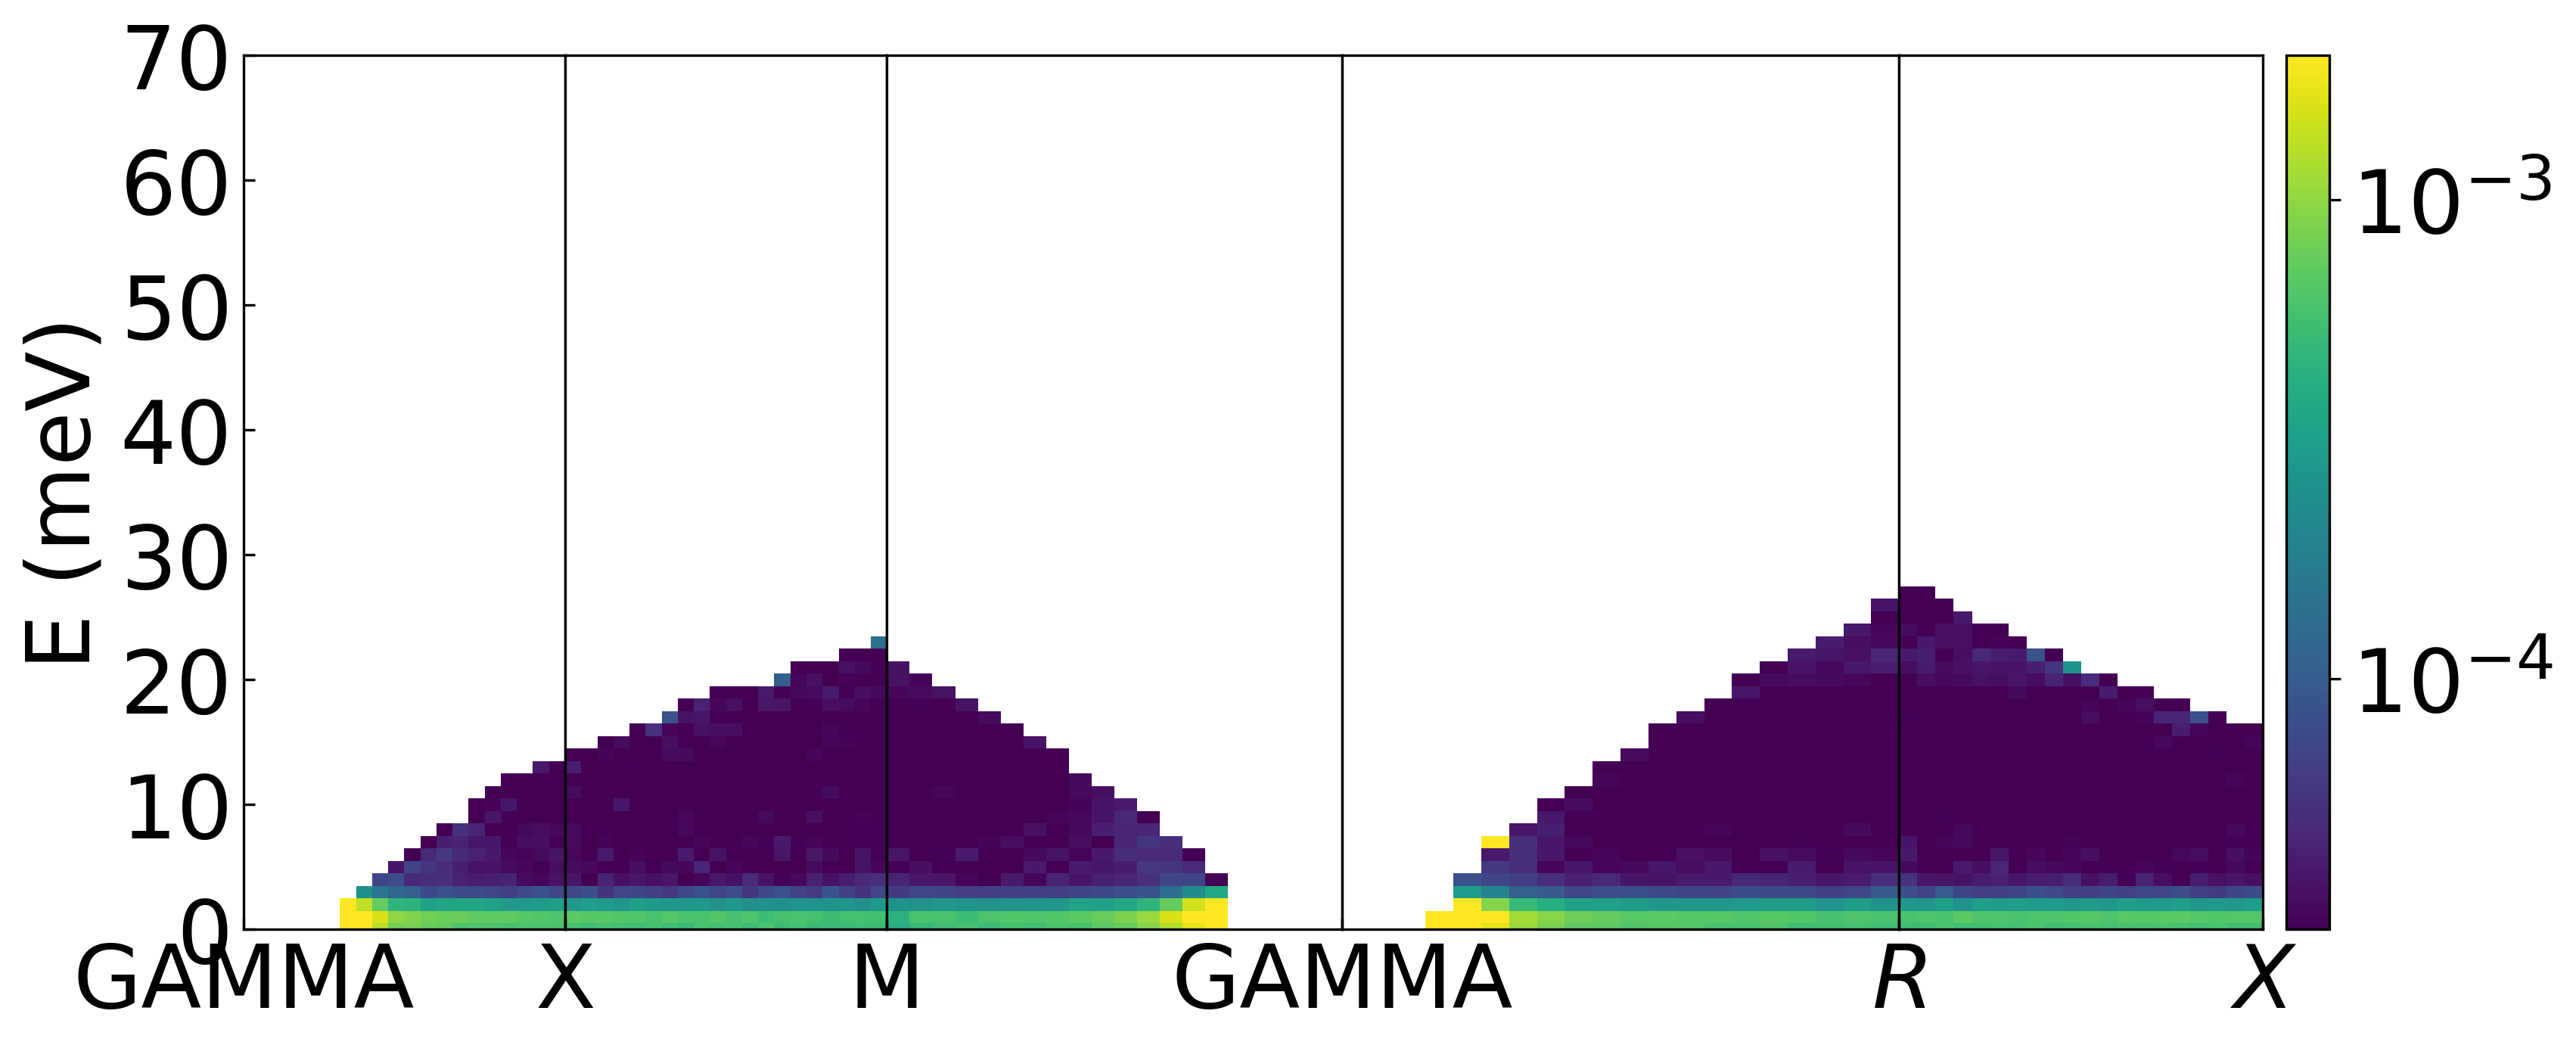

In [160]:
fig2v = plot_along_path(dsl2,3e-5,2e-3,'viridis')
fig2v.show()

# For plotting non-1st BZ

006

In [155]:
poscar = simple_read_poscar('files_for_nb/POSCAR')
path = seekpath.get_path(structure=poscar)

dsl3=[]
# APPEARS IT MAY NOT BE ABLE TO HANDLE DISCONTINUITIES IN PATH YET (e.g. R>X then R>M (path[5]))
for i in range(5): #range(len(path['path'])):
    path_seg = path['path'][i]
    q_dims_and_bins = choose_dims_and_bins(path_segment=path_seg, point_coords=path['point_coords'], perp_to_path=True, BZ_offset=np.array([0,0,6]))    
    slice_desc = make_slice_desc(q_dims_and_bins, path_seg, path['point_coords'])
    dsl3.append(slice_desc)


imp.reload(define_data)

mde_data=define_data.define_data_set()
reduce_data_to_MDE(mde_data)

for i in range(len(dsl3)):
    make_slice(mde_data[0],dsl3[i], ASCII_slice_folder='', MD_slice_folder='')

MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 16.28 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 16.28 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 16.89 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 16.09 seconds
MDNorm-[Notice] MDNorm started
MDNorm-[Notice] MDNorm successful, Duration 16.07 seconds


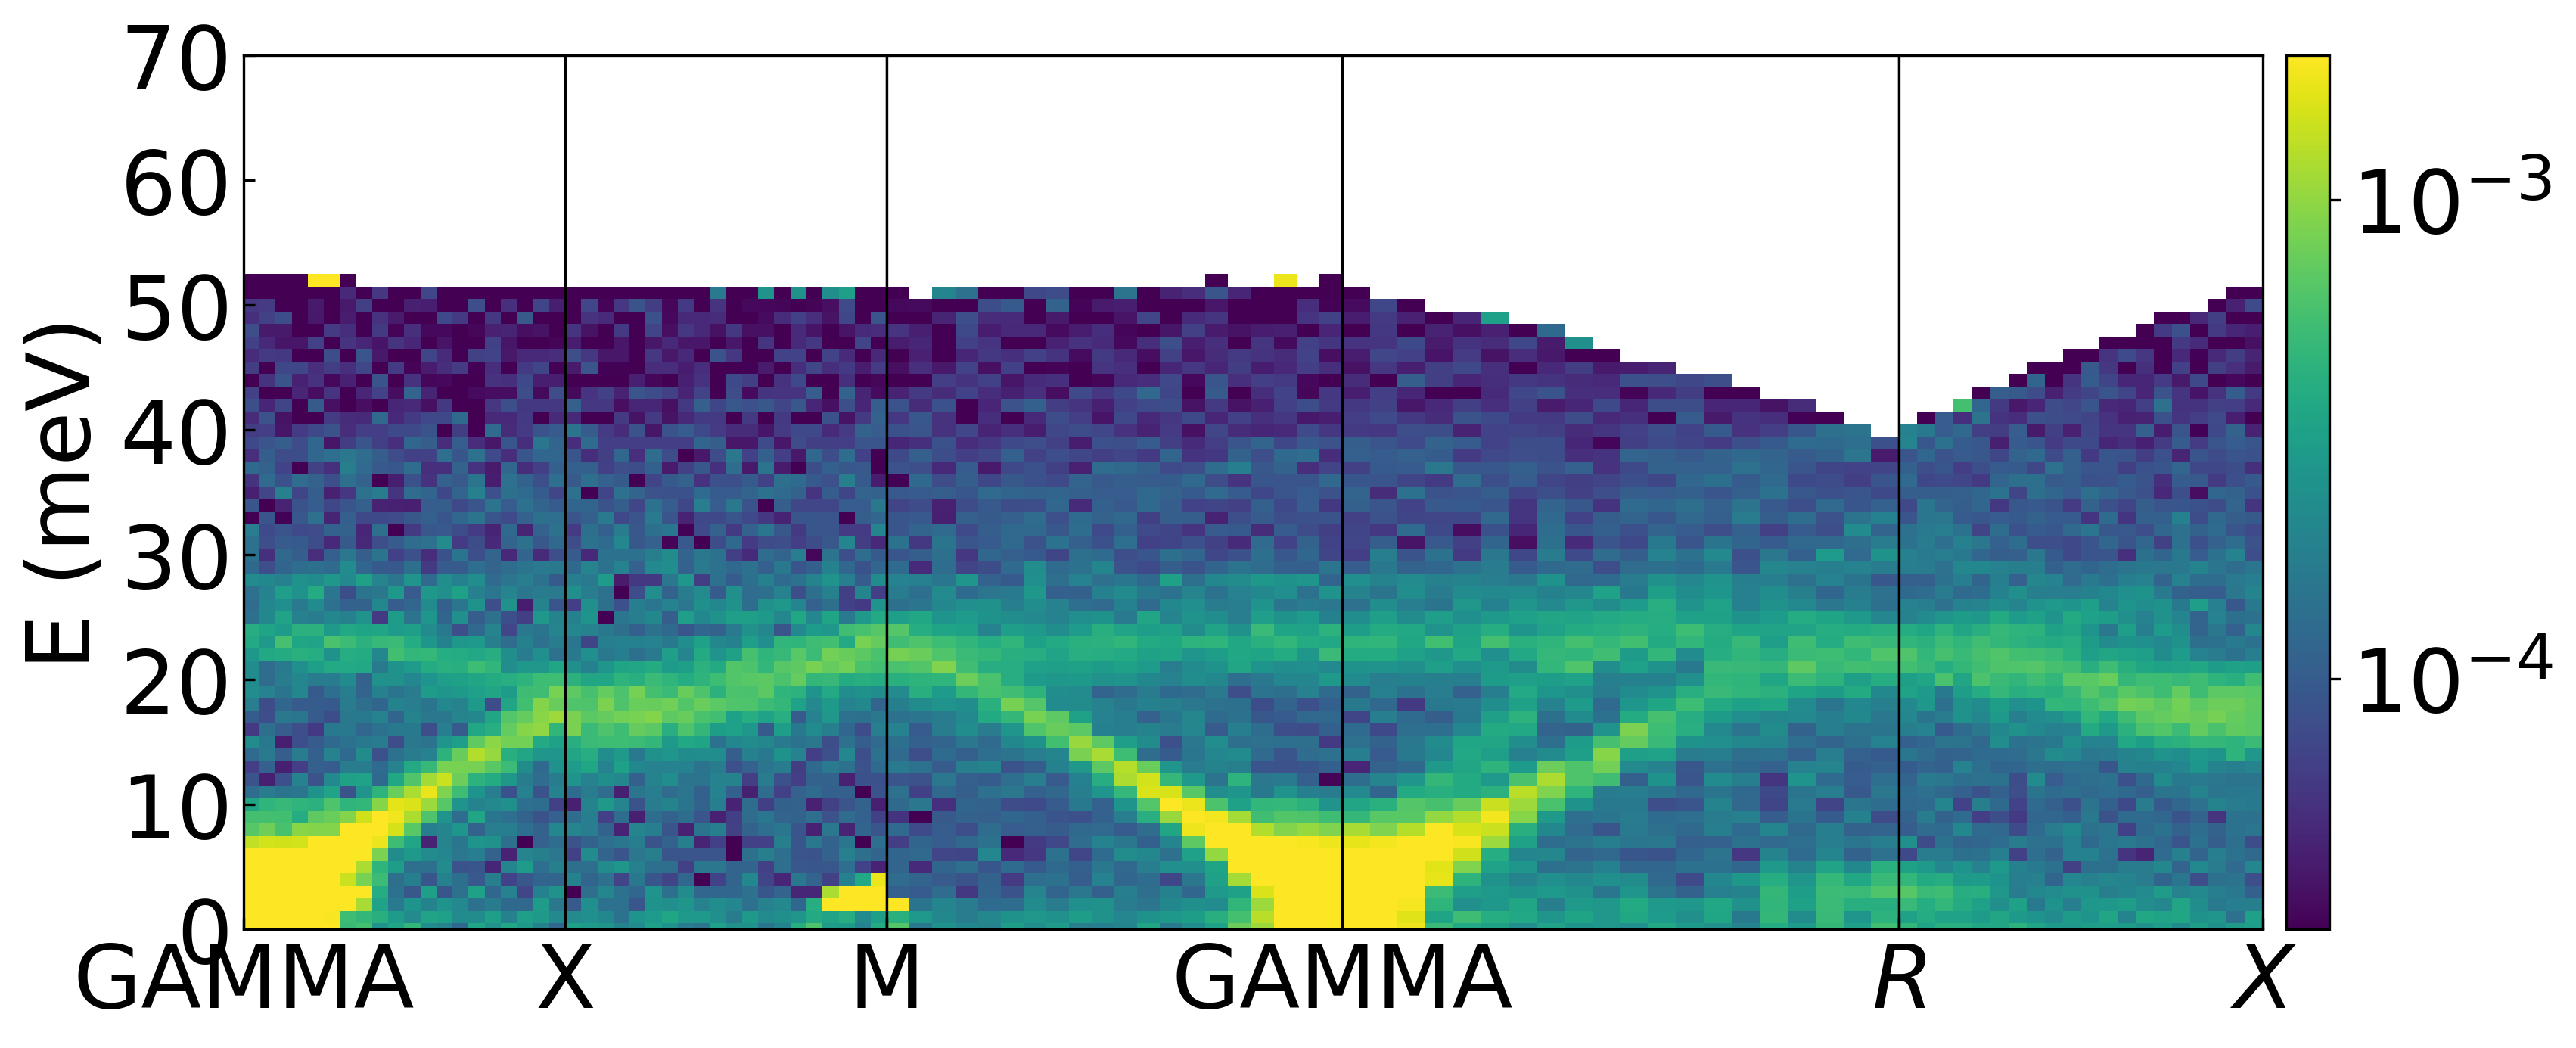

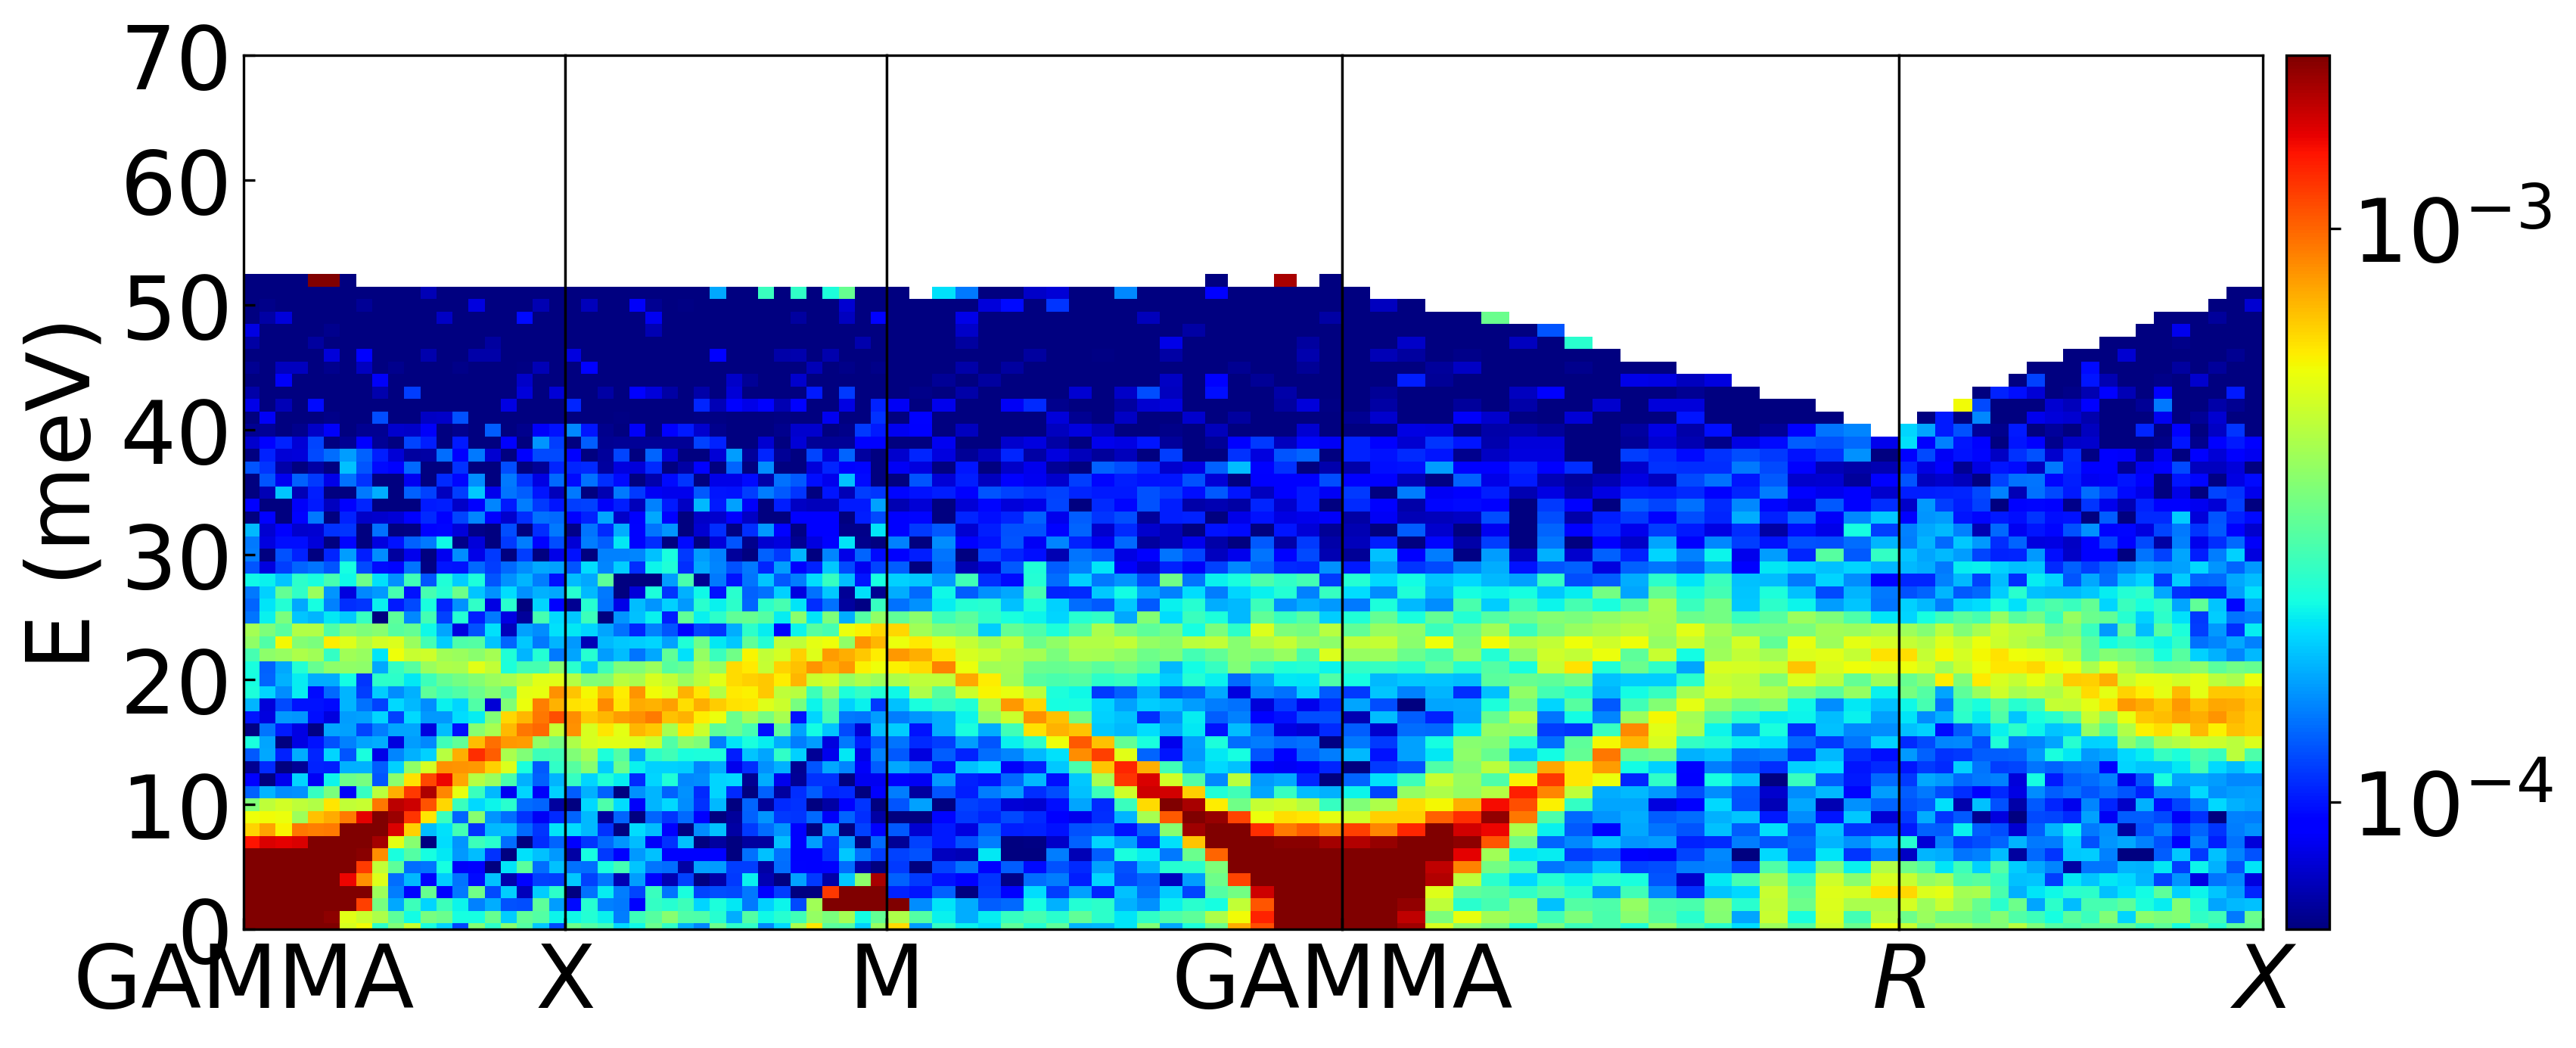

In [158]:
fig3v = plot_along_path(dsl3,3e-5,2e-3,'viridis')
fig3v.show()
fig3 = plot_along_path(dsl3,6e-5,2e-3)
fig3.show()